In [1]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

month="02"

seq_threshold = 0.4

start_year = 2012
end_year = 2021

subtype2resullt_matrix_clade = dict()
subtype2resullt_matrix_seq = dict()
subtype2all_results = dict()
subtype2model2df = dict()


model2df = defaultdict(list)

for subtype in ("h1n1", "h3n2"):
    for year in range(start_year, end_year + 1): # 2022
        domiance_models_map = {
            "lightning_logs_version_0": "our",
        }
        hi_models = {
            "max_steps_150k": "our",
        }

        vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/vaccine_scores" % \
                                (year, month, subtype, year-3, month, year, month, year-3, month, year, month)

        for file in os.listdir(vaccine_scores_path):
            model_key = None
            prob_file, exp_file = file.split("___")
            prob_file = prob_file.split("prob=")[1]
            exp_file = exp_file.split("hi=")[1]
            if prob_file in domiance_models_map and exp_file in hi_models:
                model_key = domiance_models_map[prob_file] + "___" + hi_models[exp_file]
                _df = pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv"))
                _df["year"] = [str(year)] * len(_df)
                _df["subtype"] = [ "A/" + subtype.upper()] * len(_df)
                model2df[model_key].append(_df)

for model in model2df:
    model2df[model] = pd.concat(model2df[model])
all_model2df = model2df

In [4]:
# result_matrix_clade = []
# result_matrix_seq = []
# all_results = []


results_of_our_model_clade = dict()
results_of_our_model_seq = dict()

for subtype in ("A/H3N2", "A/H1N1"):
    for model in all_model2df:
        model2df = all_model2df[model]
        model2df = model2df[model2df["subtype"] == subtype]
        
        mask_seq = ~np.isnan(model2df["gt_score_seq"])
        mask_seq = np.logical_and(mask_seq, model2df["coverage_seq"]>seq_threshold)

        spearman_rank_seq, pvalue_seq = stats.spearmanr(model2df["score"][mask_seq], model2df["gt_score_seq"][mask_seq])

        if model == "our___our":
            results_of_our_model_seq[subtype] = (spearman_rank_seq, pvalue_seq)
#             print(subtype, results_of_our_model_clade, results_of_our_model_seq)


/data/rsg/nlp/wenxian/miniconda3/envs/torchlit/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: 
The palette list has fewer values (7) than needed (10) and will cycle, which may produce an uninterpretable plot.
  


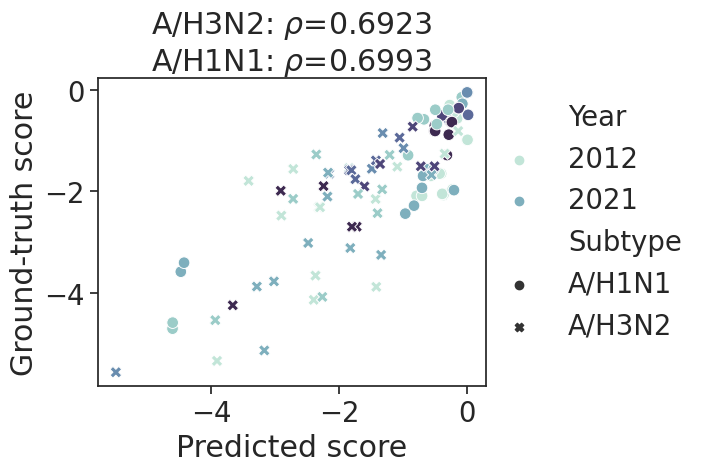

In [8]:
sns.set(font_scale=1.8, style="ticks")


our_df = all_model2df["our___our"]
our_df["neg_score"] = -our_df["score"]
our_df["neg_gt_score_clade"] = -our_df["gt_score_seq"]

our_df["Year"] = ["_%s" % x if x not in ('2012', '2021') else x for x in our_df["year"]]
our_df["Subtype"] = our_df["subtype"]

palette = sns.cubehelix_palette(start=0.5, dark=0.2, rot=-.5, n_colors=7)

fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.scatterplot(data=our_df[our_df["coverage_seq"] > seq_threshold], 
                     x="neg_score", y="neg_gt_score_clade", hue="Year", style="Subtype", s=70,
                    palette=palette, ax=ax) # , size="coverage_clade"
ax.set_xlabel("Predicted score")
ax.set_ylabel("Ground-truth score")

ax.set_title(f"A/H3N2: $\\rho$=%.4lf\nA/H1N1: $\\rho$=%.4lf" % \
             (results_of_our_model_seq["A/H3N2"][0], results_of_our_model_seq["A/H1N1"][0]))

ax.legend(frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.95, 1))

plt.savefig("figs/scores_a_h3n2_and_a_h1n1_from_2015.pdf", format='pdf', bbox_inches='tight')
plt.show()